# UNIT Project in Colab
[on GitHub](https://github.com/mingyuliutw/UNIT)


## Workspace Setup
Bash commands setting up the current session for Juputer Notebook

### Google Drive Folder Mounting
Following code mounts your google.drive to container. Choose **one** of next **two** methods.


#### Mounting (built-in)

In [1]:
print('Mounting...')
import os
from google.colab import drive
drive.mount('/drive/')
os.symlink('/drive/My Drive', '/content/drive')
!ls '/content/drive/'
print('Mounted!')

Mounting...
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive/
Colab  datasets  Graduation  README.md	UNIT
Mounted!


#### Mounting With Fuse Driver (google-drive-ocamlfuse)

In [0]:
# Mount Google.Drive with google-drive-ocamlfuse
% cd /content/
print('Installing required software')
! apt-get install -y -qq software-properties-common module-init-tools 2>&1 > /dev/null
print('Add apt-repository with Google.Drive Fuse')
! add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
print('Updating packages...')
! apt-get update -y -qq
print()'Installing google-drive-ocamlfuse fuse...')
! apt-get install -y -qq google-drive-ocamlfuse fuse
print('Authenticate Fuse in Google.Drive...')
from google.colab import auth
from oauth2client.client import GoogleCredentials
import getpass
auth.authenticate_user()
creds = GoogleCredentials.get_application_default()
! google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass('Enter auth code here: ')
! echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
print('Authenticated!')
print('Creating mount directory')
! mkdir ./drive2
print('Mounting...')
! google-drive-ocamlfuse ./drive2
! ls ./drive2
print('Mounted!')

## SSH Tunnel

In [0]:
#@markdown ## Connect to Colab session
#@markdown Using ngrok
port = 4040 #@param {type:"integer"}

print('Generate root password')
import secrets, string
password = ''.join(secrets.choice(string.ascii_letters + string.digits) for i in range(20))

print('Download ngrok')
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip
print('Setup sshd')
! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
print('Set root password')
! echo root:$password | chpasswd
! mkdir -p /var/run/sshd
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc
! echo "export LD_LIBRARY_PATH" >> /root/.bashrc

print('Run sshd')
get_ipython().system_raw('/usr/sbin/sshd -D &')

print("Copy authtoken from https://dashboard.ngrok.com/auth")
import getpass
authtoken = getpass.getpass()

print('Create tunnel')
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')
#Print root password
print("Root password: {}".format(password))
print('Get public address')
! curl -s http://localhost:${port}/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Project

### Install Dependencies
Session startup installation

In [2]:
#@markdown ## Dependencies
Project = 'google.drive' #@param ['google.drive', 'clone github'] 
copy_pre_trained_model = False #@param {type:"boolean"}

if Project == 'clone github':
    print('Cloning GitHub project...')
    !git clone https://github.com/SoleSensei/UNIT.git
    if copy_pre_trained_model:
        print('Copying PT model gta2city...')
        !mkdir /content/UNIT/models
        !mkdir /content/UNIT/outputs
        !cp -r /content/drive/UNIT/models/ /content/UNIT/
        !cp -r /content/drive/UNIT/output/ /content/UNIT/


print('Installing system packages...')
!apt-get install -y -qq axel imagemagick 2>&1 > /dev/null
print('Installing project dependencies...')
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl 2>&1 > /dev/null
!pip3 install torchvision 2>&1 > /dev/null
!pip3 install tensorboard tensorboardX 2>&1 > /dev/null
print('Complete!')

Installing system packages...
Extracting templates from packages: 100%
Installing project dependencies...
tcmalloc: large alloc 1073750016 bytes == 0x5790c000 @  0x7fa5b08372a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Complete!


## Train

In [0]:
#@markdown ## Training Winter 2 Summer
Resume_from_last_checkpoint = True #@param {type:"boolean"}
Checkpoint_every_iteration = 1000 #@param {type:"slider", min:100, max:5000, step:100}



if Resume_from_last_checkpoint:
    rsm = '--resume'
else:
    rsm = ''

import os
if not os.path.isdir('/content/drive'):
    print('=====================================================================')
    print('Session ended! Please remount google.drive and reinstall dependences!')
    print('=====================================================================')
else:
    os.chdir('/content/drive/UNIT')

    print('=====================================================================')
    print('Training a model Summer to Winter image translation')
    print('=====================================================================')
    !python train.py --config configs/unit_summer2winter_yosemite256_folder.yaml --trainer UNIT $rsm
    print('=====================================================================')
    print('Fully Trained!')
    print('=====================================================================')

Training a model Summer to Winter image translation
Resume from iteration 55500
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
Elapsed time in update: 5.841994
Elapsed time in update: 1.917917
Elapsed time in update: 1.920525
Elapsed time in update: 1.920807
Elapsed time in update: 1.915961
Elapsed time in update: 1.930754
Elapsed time in update: 1.927834
Elapsed time in update: 1.915053
Elapsed time in update: 1.920370
Elapsed time in update: 1.927915
Iteration: 00055510/01000000
Elapsed time in update: 1.928199
Elapsed time in update: 1.924712
Elapsed time in update: 1.930262
Elapsed time in update: 1.933390
Elapsed time in update: 1.933106
Elapsed time in update: 1.933174
Elapsed time in update: 1.929084
Elapsed time in update: 1.923934
Elapsed time in update: 1.928150
Elapsed time in updat

In [0]:
#@markdown ## Display images
iterations = 5004 #@param {type:"slider", min:10, max:10000, step:1}
image_size = 30 #@param {type:"slider", min:15, max:50, step:1}
iterations = int(iterations)
import os
from IPython.display import Image, display, HTML
import cv2
import matplotlib.pyplot as plt


def getTitle(name, it):
    title = ''
    if name[4] == 'a':
        title += 'Summer 2 Winter'
    else:
        title += 'Winter 2 Summer'
    if name[7:13] == '_test_':
        title += ' - Test '
    else:
        title += ' - Train '
    return title + str(it)

def displayImage(file, title):
    image = cv2.imread(file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(image_size,image_size))
    plt.title(title);
    plt.imshow(image)
    plt.grid(False)

os.chdir('/content/drive/UNIT/outputs/unit_summer2winter_yosemite256_folder/images/')
# print(os.getcwd())
print(f'Selected iterations: {iterations}')
for r, d, f in os.walk('./'):
    file = f[0]
    num_pit = int(file[-12:-4])
    title = getTitle(file, num_pit)
    displayImage(file, title)
    for file in f[1:]:
        if file[-12:-4] != '_current':
            num_it  = int(file[-12:-4])
            if num_it - num_pit >= iterations or num_it == num_pit:
                title = getTitle(file, num_it)
                displayImage(file, title)
                num_pit = num_it






<!-- ![]()
 ![Google's logo](/content/drive/UNIT/outputs/unit_summer2winter_yosemite256_folder/images/gen_a2b_test_00000010.png) -->


## Test

/drive/My Drive/UNIT
Testing: gta2city
Load experiment setting
Setup model and data loader
Start testing
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
Testing complete!
Input


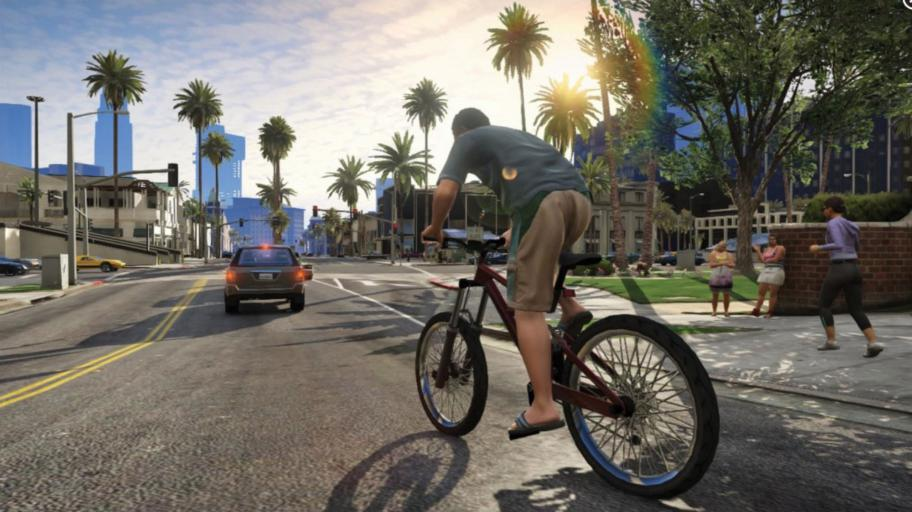

Output


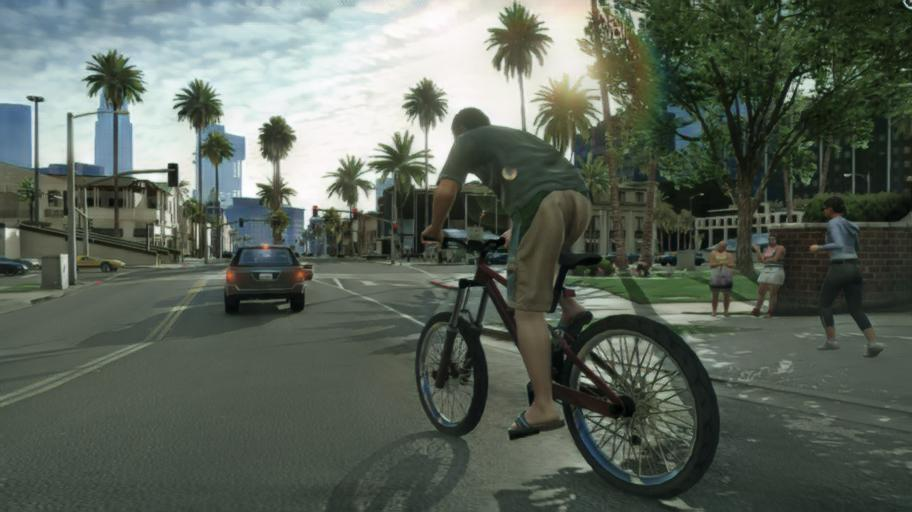

Testing: city2gta
Load experiment setting
Setup model and data loader
Start testing
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
Testing complete!
Input


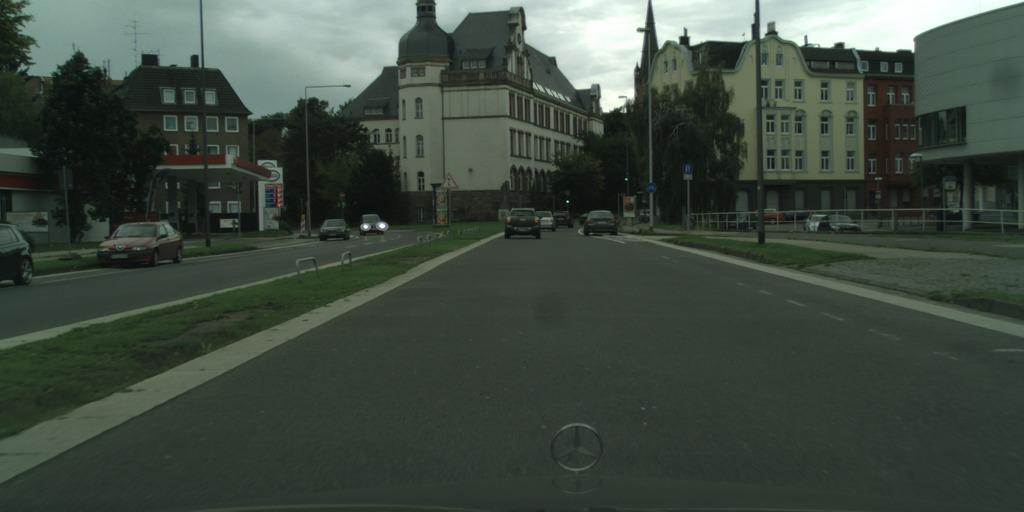

Output


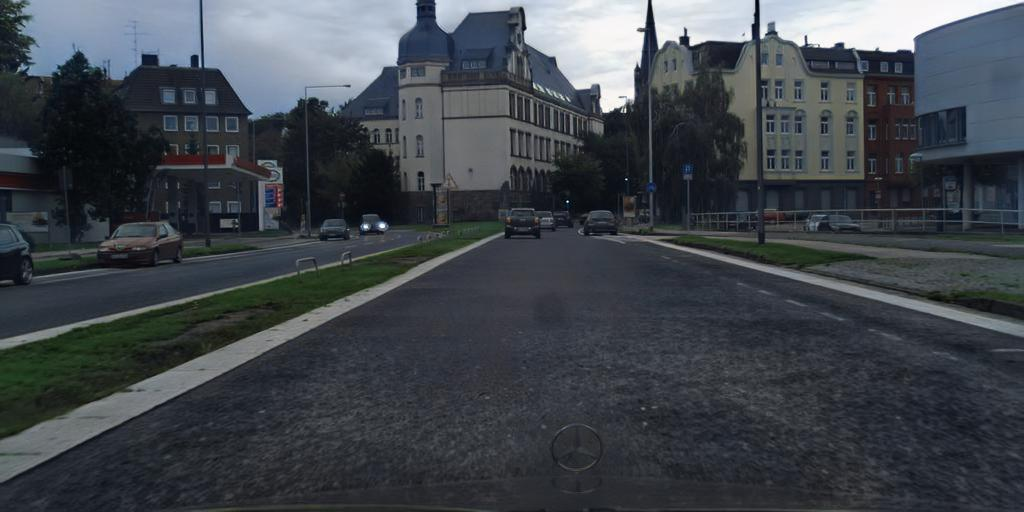

In [0]:
from IPython.display import Image, display
import os

#@markdown ## Testing on PT models
Model = "gta2city" #@param ['gta2city', 'day2night', 'summer2winter']
gta2city = False #@param {type:"boolean"}
city2gta = False #@param {type:"boolean"}


if not os.path.isdir('/content/drive'):
    print('=====================================================================')
    print('Session ended! Please remount google.drive and reinstall dependences!')
    print('=====================================================================')
    assert(False)
    
os.chdir('/content/drive/UNIT')


if gta2city:
    print('=====================================================================')
    print('Testing: gta2city')
    print('=====================================================================')


    ! python test.py --trainer UNIT --config configs/unit_gta2city_list.yaml --input inputs/gta3.jpg --output_folder results/gta2city --checkpoint models/unit_gta2city.pt --a2b 1

    print('=====================================================================')
    print('Input')
    display(Image('/content/drive/UNIT/results/gta2city/input.jpg', width=800))
    print('Output')
    display(Image('/content/drive/UNIT/results/gta2city/output.jpg', width=800))

if city2gta:
    print('=====================================================================')
    print('Testing: city2gta')
    print('=====================================================================')
   
    ! python test.py --trainer UNIT --config configs/unit_gta2city_list.yaml --input inputs/city_example.jpg --output_folder results/city2gta --checkpoint models/unit_gta2city.pt --a2b 0

    print('=====================================================================')
    print('Input')
    display(Image('/content/drive/UNIT/results/city2gta/input.jpg', width=800))
    print('Output')
    display(Image('/content/drive/UNIT/results/city2gta/output.jpg', width=800))